# Example 4: Spiral classification
## SI Section 2.6: Spiral classification
### Reference: INN paper https://arxiv.org/abs/2404.10296

In this example, we conduct a simple classification task called spiral classification. 

The first step is to import the pyinn package.

In [6]:
from jax import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)
import os, sys
import yaml
import importlib

from pyinn import dataset_classification, dataset_regression, model, train, plot # with pyinn library


First, set up GPUs

In [7]:
gpu_idx = 2  # set which GPU to run on Athena
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # GPU indexing
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)  # GPU indexing

Next, we create the dataset and store it in /data directory in the current folder. The created datafile will be named as data_name = "spiral.csv"

In [8]:
# Define configuration of the dataset & training
data_name = 'spiral' # data file name in /data directory
config = {}
config["DATA_PARAM"] = {
    "data_name": data_name,  # name of the dataset
    "input_col": [0,1],  # input columns in the dataset
    "output_col": [2], # output columns in the dataset
    "nclass" : 2,

    "bool_data_generation": True,  # data is already stored and splitted
    "split_ratio": [0.7, 0.15, 0.15],  # [0.7,0.15,0.15]

    "bool_normalize": True,  # whether we normalize the input data or not
    "bool_image": False,  # whether the data is image or not
    "bool_shuffle": True  # whether we shuffle the data
}
config["TRAIN_PARAM"] = {
    "num_epochs_INN": 5,
    "num_epochs_MLP": 100,
    "batch_size": 128,
    "learning_rate": 1e-1,
    "bool_train_acc": False,

    "validation_period": 100,
    "bool_denormalize": False,  # or True, whether we denormalize when measuring errors
    "error_type": "accuracy",  # rmse or mse
    "patience": 10
}

# Create dataset and save it in /data directory
data = dataset_classification.Data_classification(data_name, config)
  

loaded 10000 datapoints from spiral dataset


Now the datafile was created at /data/spiral.csv. Let us visualize the data using pandas.

In [9]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(f'./data/{data_name}.csv')

# Display the first few rows
df.head()

,x1,x2,u
0,4.637951,-0.341473,1.0
1,-1.558261,-3.563716,1.0
2,2.316029,0.215056,0.0
3,1.644817,1.354902,0.0
4,1.969055,1.593401,0.0


The datafile contains 3 columns: x1, x2, and u. The u denotes the class. Let us plot the data.

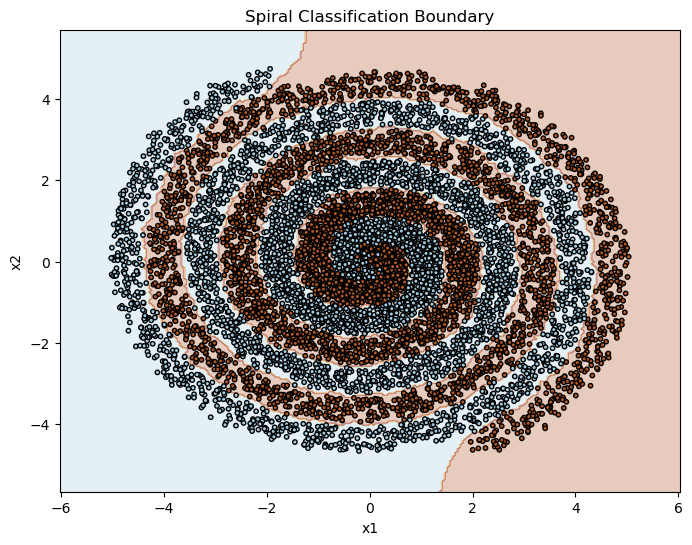

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Read the dataframe `df` and convert it to a numpy array (excluding headings) using:

X = df[['x1', 'x2']].values
y = df['u'].values

# Train a simple classifier (replace with your model if needed)
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X, y)

# Create a mesh grid for plotting decision boundary
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary and data points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired, s=10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Spiral Classification Boundary')
plt.show()

Next, we define INN hyperparameters. According to Table S7 of the INN paper's SI, the following hyperparameters were used.

* nmode: number of modes; integer

nnmode: 10

* nseg: number of segments for each dimension; integer or a list of integers

nseg: 20

* s_patch; integer, 0 <= s_patch < nseg/2

s_patch: 2

* INN activation; string

INN activation: polynomial

* p_order; integer, p_order <= s_patch

p_order: 2

In [11]:
config["MODEL_PARAM"] = {
    "nmode": 10,
    "nseg": 20,
    "s_patch": 2,
    "INNactivation": "polynomial", # INN activation function, can be 'polynomial', 'sinusoidal', 'exponential', 'sigmoid', 'tanh', 'gelu'
    "p_order": 2,
    ### non-adjustable parameters
    "radial_basis": "cubicSpline",
    "alpha_dil": 20 # this is a dilation parameter and will be set as 20 for default.
}

Let's finalize the configuration file.

In [12]:
if config["MODEL_PARAM"]["s_patch"] > 0:
    config['interp_method'] = "nonlinear" # nonlinear (Q=2 INN message passing) interpolation
elif config["MODEL_PARAM"]["s_patch"] == 0:
    config['interp_method'] = "linear" # linear (Q=1 INN message passing) interpolation
config['TD_type'] = "CP"

Train INN (Q=2 nonlinear interpolation)

In [13]:
classifier = train.Classification_INN(data, config)  # HiDeNN-TD regressor class
classifier.train()  # Train module

    


edex_max / ndex_max: 6 / 5
------------ INN CP nonlinear, nmode: 10, nseg: 20, s=2, P=2 -------------
# of training parameters: 840
Epoch 1
	Train accuracy: 6.6629e+01
	2.92 seconds per epoch
Epoch 2
	Train accuracy: 8.4814e+01
	1.81 seconds per epoch
Epoch 3
	Train accuracy: 9.4671e+01
	1.46 seconds per epoch
Epoch 4
	Train accuracy: 9.5886e+01
	1.28 seconds per epoch
Epoch 5
	Train accuracy: 9.6100e+01
	1.17 seconds per epoch
Training took 5.8433 seconds/ 1.17 seconds per epoch
Test
	Test Accuracy: 95.67%
	Test took 0.9583 seconds
	Inference time: 0.0000 seconds


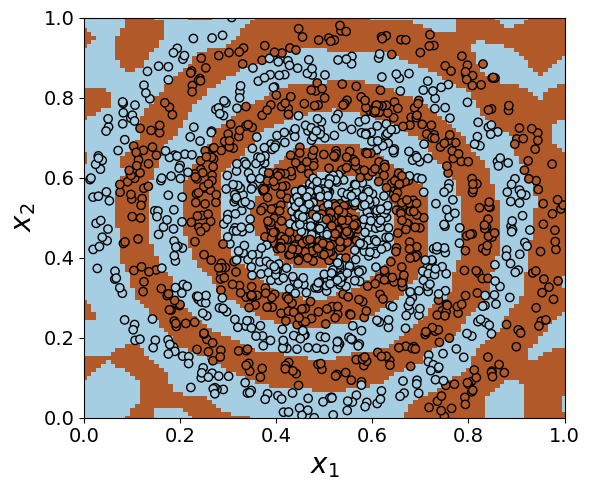

In [14]:
## plot
config["PLOT"] = {"bool_plot": True,
                  "plot_in_axis": [0,1],  # plot input axis
                  "plot_out_axis": [2]}  # plot output axis

plot.plot_classification(classifier, data, config)